# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

In [203]:
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import operator

## Data load

In [204]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)
        
# loading the match data
matches={}
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

# loading the competitions data
competitions={}
with open('./data/competitions.json') as json_data:
    competitions = json.load(json_data)

# loading the teams data
teams={}
with open('./data/teams.json') as json_data:
    teams = json.load(json_data)

In [205]:
matches.keys()

dict_keys(['Italy', 'England', 'Germany', 'France', 'Spain', 'European_Championship', 'World_Cup'])

### JSON to DataFrame

In [206]:
teams_df = pd.DataFrame(teams)
players_df = pd.DataFrame(players)
competitions_df = pd.DataFrame(competitions)
matches_df = {
    'Italy': pd.DataFrame(matches['Italy']),
    'England': pd.DataFrame(matches['England']),
    'Germany': pd.DataFrame(matches['Germany']),
    'France': pd.DataFrame(matches['France']),
    'Spain': pd.DataFrame(matches['Spain']),
    'European_Championship': pd.DataFrame(matches['European_Championship']),
    'World_Cup': pd.DataFrame(matches['World_Cup'])
}
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

## Italian first division

In [207]:
competitions_df

,name,wyId,format,area,type
0,Italian first division,524,Domestic league,"{'name': 'Italy', 'id': '380', 'alpha3code': '...",club
1,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,Spanish first division,795,Domestic league,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,French first division,412,Domestic league,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
4,German first division,426,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
5,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international
6,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international


In [208]:
italian_teams_df = teams_df[(teams_df['area'].apply(lambda x: x.get('name')) == 'Italy') & (teams_df['type'] == 'club')]

In [209]:
teams_matches = {}
#prints the name and code of each team
for team in italian_teams_df.iterrows():
    teams_matches[team[1]['wyId']] = matches_df['Italy'][matches_df['Italy']['teamsData'].apply(lambda x: x.get(str(team[1]['wyId'])) != None)]
    teams_matches[team[1]['wyId']].sort_values(by='gameweek')

In [210]:
len(teams_matches.keys())

20

In [211]:
italian_events_df = events_df['Italy'][events_df['Italy']['playerId'] != 0]
italian_events_df = italian_events_df.sort_values(by=['matchId', 'playerId', 'matchPeriod', 'eventSec'])

In [213]:
italian_events_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
64,1,Ground loose ball duel,"[{'id': 701}, {'id': 1802}]",114,"[{'y': 66, 'x': 32}, {'y': 68, 'x': 30}]",2575959,Duel,3158,1H,190.033380,13,180424030
71,8,Simple pass,[{'id': 1801}],114,"[{'y': 76, 'x': 37}, {'y': 90, 'x': 40}]",2575959,Pass,3158,1H,201.317410,85,180424039
75,8,Simple pass,[{'id': 1801}],114,"[{'y': 79, 'x': 30}, {'y': 77, 'x': 32}]",2575959,Pass,3158,1H,210.057782,85,180424047
86,8,Simple pass,[{'id': 1801}],114,"[{'y': 37, 'x': 64}, {'y': 66, 'x': 73}]",2575959,Pass,3158,1H,240.645201,85,180424066
89,8,High pass,"[{'id': 302}, {'id': 901}, {'id': 1801}]",114,"[{'y': 75, 'x': 71}, {'y': 33, 'x': 95}]",2575959,Pass,3158,1H,247.586484,83,180424076
...,...,...,...,...,...,...,...,...,...,...,...,...
647301,8,Simple pass,[{'id': 1801}],413041,"[{'y': 26, 'x': 54}, {'y': 63, 'x': 60}]",2576338,Pass,3193,2H,2658.089531,85,253567073
647315,3,Throw in,[{'id': 1801}],413041,"[{'y': 0, 'x': 19}, {'y': 37, 'x': 10}]",2576338,Free Kick,3193,2H,2690.255785,36,253567089
647354,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 60, 'x': 33}, {'y': 57, 'x': 25}]",2576338,Duel,3193,2H,2798.923456,11,253567142
647356,8,Simple pass,[{'id': 1801}],413041,"[{'y': 57, 'x': 25}, {'y': 43, 'x': 31}]",2576338,Pass,3193,2H,2801.914483,85,253567136


In [214]:
distances = {}
for team in italian_teams_df.iterrows():
    distances[team[1]['wyId']] = {}
distances

{3204: {},
 3157: {},
 3159: {},
 3158: {},
 3315: {},
 3166: {},
 3164: {},
 3165: {},
 3162: {},
 3163: {},
 3161: {},
 3219: {},
 3173: {},
 3172: {},
 3176: {},
 3185: {},
 3187: {},
 3197: {},
 3194: {},
 3193: {}}

In [215]:
distance = 0
playerId = -1
position = (0,0)
teamId = -1
gameweek = 0
for event in italian_events_df.iterrows():
    if event[1]['playerId'] != playerId:
        if distance != 0 and playerId != -1:
            if playerId not in distances[teamId]:
                distances[teamId][playerId] = [[gameweek, distance]]
            else:
                distances[teamId][playerId].append([gameweek, distance])
        distance = 0
        playerId = event[1]['playerId']
        teamId = event[1]['teamId']
        position = (event[1]['positions'][0]['x'], event[1]['positions'][0]['y'])
        gameweek = matches_df['Italy'][matches_df['Italy']['wyId'] == event[1]['matchId']]['gameweek'].to_numpy()[0]
    else:
        distance += math.dist(position, (event[1]['positions'][0]['x'], event[1]['positions'][0]['y']))
        position = (event[1]['positions'][0]['x'], event[1]['positions'][0]['y'])

if distance != 0 and playerId != -1:
    distance += math.dist(position, (event[1]['positions'][0]['x'], event[1]['positions'][0]['y']))
    if playerId not in distances[teamId]:
        distances[teamId][playerId] = [[gameweek, distance]]
    else:
        distances[teamId][playerId].append([gameweek, distance])    

In [221]:
teams_distances = distances

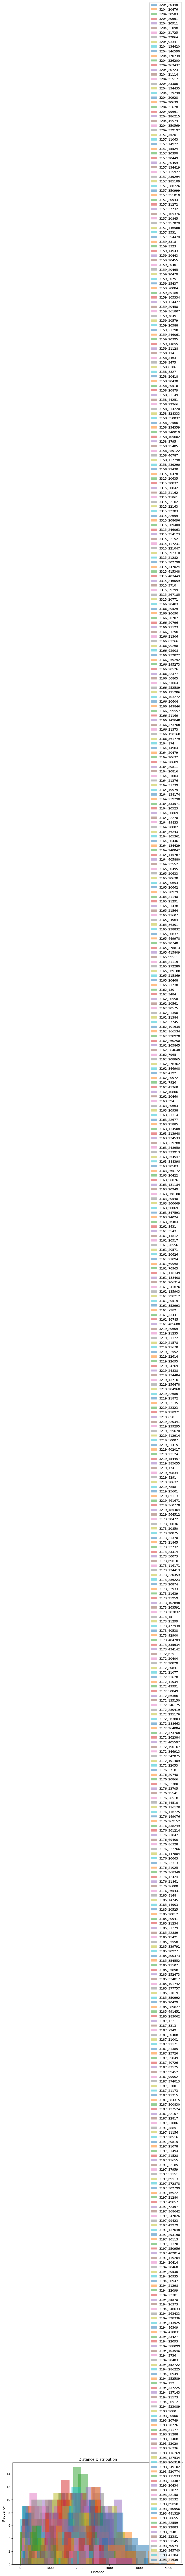

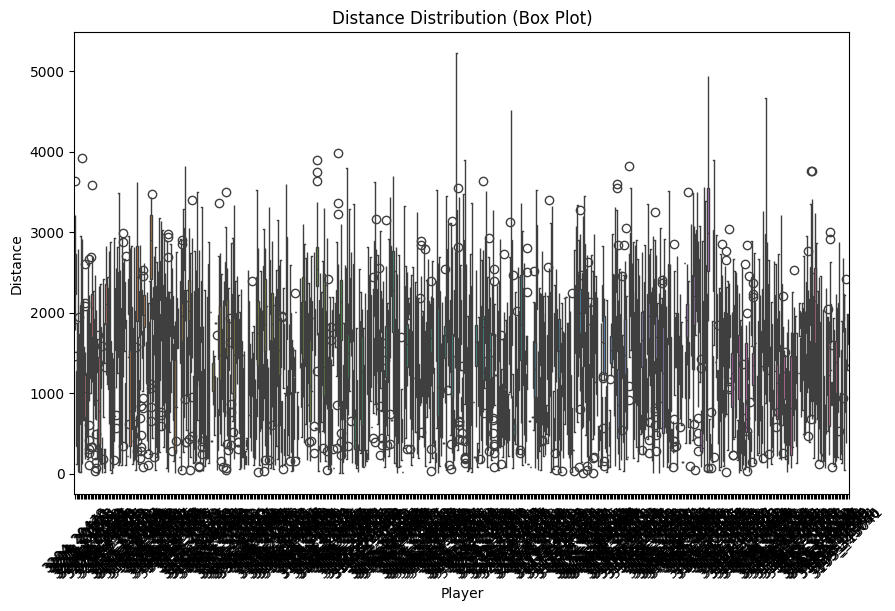

KeyboardInterrupt: 

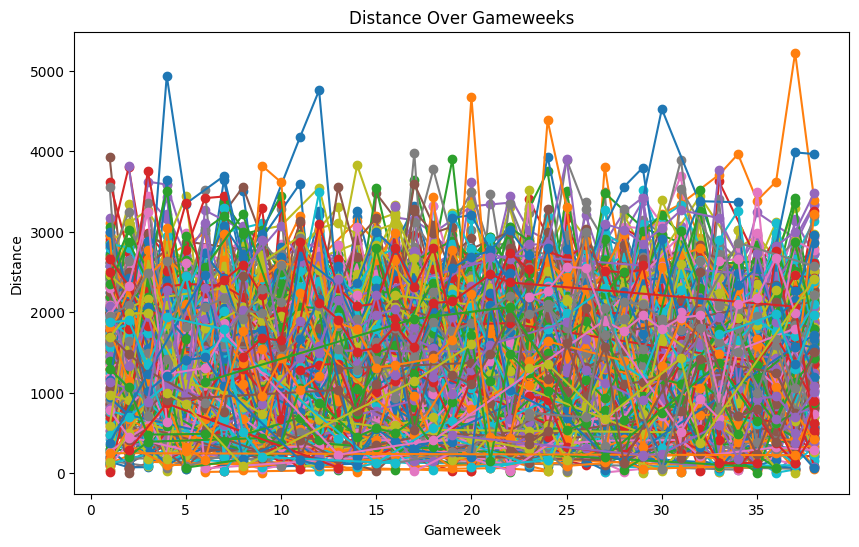

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(10, 6))
for team, players in teams_distances.items():
    for player, distances in players.items():
        distances = [distance[1] for distance in distances]
        plt.hist(distances, bins=10, alpha=0.5, label=f'{team}_{player}')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distance Distribution')
plt.legend()
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
distances_data = []
labels = []
for team, players in teams_distances.items():
    for player, distances in players.items():
        distances = [distance[1] for distance in distances]
        distances_data.append(distances)
        labels.append(f'{team}_{player}')
sns.boxplot(data=distances_data, orient='v')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
plt.xlabel('Player')
plt.ylabel('Distance')
plt.title('Distance Distribution (Box Plot)')
plt.show()

# Line Plot
plt.figure(figsize=(10, 6))
for team, players in teams_distances.items():
    for player, distances in players.items():
        gameweeks = [distance[0] for distance in distances]
        distances = [distance[1] for distance in distances]
        plt.plot(gameweeks, distances, marker='o', label=f'{team}_{player}')
plt.xlabel('Gameweek')
plt.ylabel('Distance')
plt.title('Distance Over Gameweeks')
plt.legend()
plt.show()

# Bar Plot
plt.figure(figsize=(10, 6))
average_distances = {}
for team, players in teams_distances.items():
    for player, distances in players.items():
        distances = [distance[1] for distance in distances]
        average_distance = sum(distances) / len(distances)
        average_distances[f'{team}_{player}'] = average_distance
plt.bar(average_distances.keys(), average_distances.values())
plt.xlabel('Player')
plt.ylabel('Average Distance')
plt.title('Average Distance of Players')
plt.xticks(rotation=45)
plt.show()

# Scatter Plot
plt.figure(figsize=(10, 6))
for team, players in teams_distances.items():
    for player, distances in players.items():
        gameweeks = [distance[0] for distance in distances]
        distances = [distance[1] for distance in distances]
        plt.scatter(gameweeks, distances, label=f'{team}_{player}')
plt.xlabel('Gameweek')
plt.ylabel('Distance')
plt.title('Distance Scatter Plot')
plt.legend()
plt.show()

# Violin Plot
plt.figure(figsize=(10, 6))
distances_data = []
labels = []
for team, players in teams_distances.items():
    for player, distances in players.items():
        distances = [distance[1] for distance in distances]
        distances_data.append(distances)
        labels.append(f'{team}_{player}')
sns.violinplot(data=distances_data, orient='v')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
plt.xlabel('Player')
plt.ylabel('Distance')
plt.title('Distance Distribution (Violin Plot)')
plt.show()
